# Lab 1: image rectification

This lab has two main goals:

1) Get more familiar with the hierarchy of 2D transformation <br>

2) Remove the projective distortion of an image of a planar object (image rectification)

The following file combines some text cells (Markdown cells) and code cells. Some parts of the code need to be completed. All tasks you need to complete are marked in <span style='color:Green'> green.  </span>

In [1]:
from math import ceil

from PIL import Image, ImageDraw
import numpy as np
from scipy.ndimage import map_coordinates

import homographies as Hf
import rectification as rctf
from utils import work_with_numpy, line_draw, plot_img, compute_angle, angle_diff, crop, get_equation, get_inters

## **1. Applying image transformations**

In this first part of the lab you will apply different types of 2D transformations to a given image. For that, you first need to create a function that applies a homography to animage.

<span style='color:Green'> - Create the function  *apply_H* that gets as input a homography and
an image and returns the image transformed by the homography. </span>

Note: The size of the transformed image has to be automatically set so as to 
contain the whole transformed image.
You will need to interpolate the image values at some points, for that,
you may use the function *scipy.ndimage.map_coordinates*

In [2]:
def get_transformed_pixels_coords(img, H, shift=None):
    ys, xs = np.indices(img.shape[:2]).astype("float64")
    if shift is not None:
        ys += shift[1]
        xs += shift[0]
    ones = np.ones(img.shape[:2])
    coords = np.stack((xs, ys, ones), axis=2).reshape((-1, 3))
    coords_H = (H @ coords.reshape(-1, 3).T).T
    coords_H /= coords_H[:, 2, np.newaxis]
    cart_H = coords_H[:, :2]
    return cart_H.reshape((*img.shape[:2], 2))


@work_with_numpy
def apply_H(img, H, see_translation=False):
    H_inv = np.linalg.inv(H)
    new_coords = get_transformed_pixels_coords(img, H)
    min_x, min_y = np.min(new_coords[:, :, 0]), np.min(new_coords[:, :, 1])
    max_x, max_y = np.max(new_coords[:, :, 0]), np.max(new_coords[:, :, 1])
    size_x, size_y = ceil(max_x - min_x), ceil(max_y - min_y)
    if see_translation:
        print("If you want to use it fix the TODO near the return statement")
        # TODO: ?? optional by dani: see the translation
        tx = int(H[0, 2])
        ty = int(H[1, 2])
        out_full = np.zeros((size_x + abs(ty), size_y + abs(tx), 3))
        out = out_full[ty:, tx:, :]
    else:
        out = np.zeros((size_y, size_x, 3))
    shift = (min_x, min_y)
    interpolation_coords = get_transformed_pixels_coords(out, H_inv, shift=shift)
    interpolation_coords[:, :, [0, 1]] = interpolation_coords[:, :, [1, 0]]
    interpolation_coords = np.swapaxes(np.swapaxes(interpolation_coords, 0, 2), 1, 2)
    out_values = [
        map_coordinates(img[:, :, col], interpolation_coords) for col in range(3)
    ]
    out[:, :, 0] = out_values[0]
    out[:, :, 1] = out_values[1]
    out[:, :, 2] = out_values[2]
    if see_translation:
        # TODO We have to return other shift
        print("WARNING(STAN) I haven't tested the see_translation")
        return out_full.astype("uint8"), shift
    else:
        return out.astype("uint8"), shift

### **1.1 Similarities**

<span style='color:Green'> - Complete the code below by generating a matrix H which produces a similarity transformation. </span>

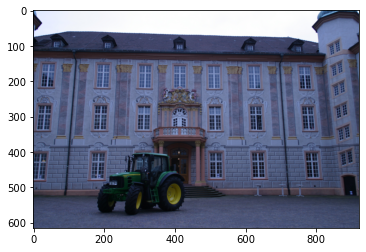

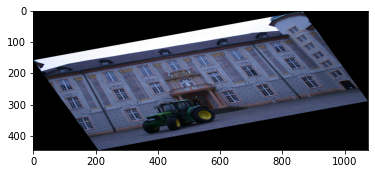

In [3]:
img_path = "./Data/0005_s.png"
I = Image.open(img_path)

R = Hf.rotate(-20)
S = Hf.scale(1, 0.5)
H_sim = S @ R  # matrix multiplication
H_sim[0:2, 2] += Hf.translate(1000, 10)[0:2, 2]

I_sim, _ = apply_H(np.array(I), H_sim)

plot_img(I)
plot_img(I_sim)

### **1.2 Affinities**

<span style='color:Green'> - Complete the code below by generating a matrix H which produces an affine transformation.  </span>

<span style='color:Green'> - Decompose the affinity in four transformations: two
rotations, a scale, and a translation (you may use function *numpy.linalg.svd* for that).  </span>

<span style='color:Green'> - Verify that the product of the four previous transformations
produces the same matrix H as above.  </span>

<span style='color:Green'> - verify that the proper sequence of the four previous
transformations over the image I produces the same transformed image as before.  </span>

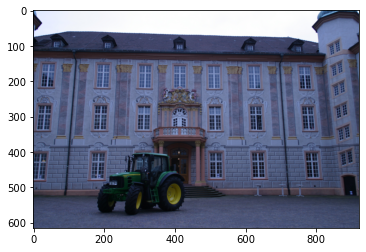

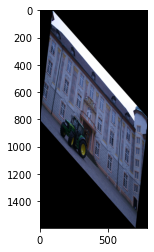

In [4]:
aff_theta, aff_tau, aff_sx, aff_sy, aff_tx, aff_ty = 26, 39, 0.7, 1.6, 300, 50

H_aff = Hf.affinity(aff_theta, aff_tau, aff_sx, aff_sy, aff_tx, aff_ty)

I_aff, _ = apply_H(I, H_aff)

#plot_img(I_aff)

theta_test = Hf.rotate(aff_theta)
tau_test = Hf.rotate(aff_tau)
# decompose the affinity in four transformations: two
# rotations, a scale, and a translation
U, D, V = np.linalg.svd(H_aff, full_matrices=False)
phi = V
phi_minus = V.T
theta = U @ V
D_mat = Hf.id()
D_mat[0, 0] = D[0]
D_mat[1, 1] = D[1]
D_mat[2, 2] = D[2]


# verify that the product of the four previous transformations
# produces the same matrix H as above
A_decomp = theta @ phi_minus @ D_mat @ phi

# verify that the proper sequence of the four previous
# transformations over the image I produces the same image I2 as before
I_aff_decomp, _ = apply_H(I, A_decomp)
plot_img(I)
plot_img(I_aff_decomp)

### **1.3 Projective transformations (Homographies)**

<span style='color:Green'> - Complete the code below by generating a matrix H which produces a projective transformation.  </span>

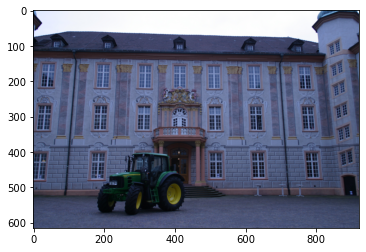

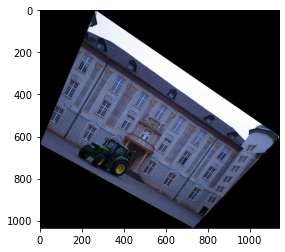

In [5]:
H_pro = Hf.projective(25, 45, 1.2, 1.6, 300, 0, 0.0002, 0.0005)

I_proj, _ = apply_H(I, H_pro)
plot_img(I)
plot_img(I_proj)

## **2. Affine Rectification**

This step is needed in order to rectify an image in a stratified way, where we first perform affine rectification (current section) and then metric rectification (Section 3).

In [6]:
# load images and lines
img_path = "./Data/0000_s.png"
I = Image.open(img_path)

lines_path = "./Data/0000_s_info_lines.txt"
A = np.loadtxt(lines_path)

# points of interest
i = 423 # line index
p1 = [A[i, 0], A[i, 1], 1] # initial point in line i
p2 = [A[i, 2], A[i, 3], 1] # final point in line i
i = 239
p3 = [A[i, 0], A[i, 1], 1]
p4 = [A[i, 2], A[i, 3], 1]
i = 711
p5 = [A[i, 0], A[i, 1], 1]
p6 = [A[i, 2], A[i, 3], 1]
i = 564
p7 = [A[i, 0], A[i, 1], 1]
p8 = [A[i, 2], A[i, 3], 1]

In [7]:
l1, l2, l3, l4 = np.cross(p1, p2), np.cross(p3, p4), np.cross(p5, p6), np.cross(p7, p8)

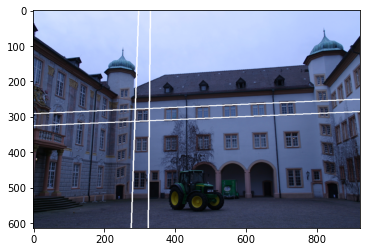

In [8]:
# show the chosen lines in the image
canv = ImageDraw.Draw(I)
point_color = (0, 0, 255)
line_draw(l1, canv, I.size)
line_draw(l2, canv, I.size)
line_draw(l3, canv, I.size)
line_draw(l4, canv, I.size)

# The displayed lines will alter image I so we have to reopen the original image after the plot
plot_img(I)
I = Image.open(img_path)

<span style='color:Green'> - Compute the homography that affinely rectifies the image </span>

<span style='color:Green'> - Compute the transformed lines lr1, lr2, lr3, lr4 and
      show the transformed lines in the transformed image. </span>
      
<span style='color:Green'> - To evaluate the results, compute the angle between the different pair 
      of lines before and after the image transformation. </span>

Angles before transform
l1 v l2 = 0.09918160389524644
l1 v l3 = 85.45401946339823
l3 v l4 = 1.3435373042190044
Angles after transform
lr1 v lr2 = 0.0
lr1 v lr3 = 72.64082077686572
lr3 v lr4 = 3.552713678800501e-15


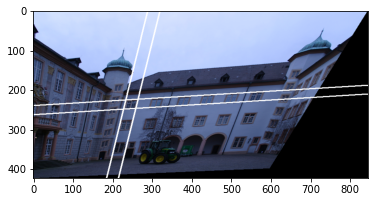

In [9]:
H_arec = rctf.affine_rectification(l1, l2, l3, l4)

img_arec, shift = apply_H(I, H_arec)
H_inv_shift = Hf.translate(shift[0], shift[1])
H_arec_inv = np.linalg.inv(H_arec) @ H_inv_shift
H_arec = np.linalg.inv(H_arec_inv)

lr1, lr2, lr3, lr4 = (
    H_arec_inv.T @ l1,
    H_arec_inv.T @ l2,
    H_arec_inv.T @ l3,
    H_arec_inv.T @ l4,
)

img_arec_nl = img_arec.copy()

size = img_arec.size
canv = ImageDraw.Draw(img_arec)
line_draw(lr1, canv, size)
line_draw(lr2, canv, size)
line_draw(lr3, canv, size)
line_draw(lr4, canv, size)

plot_img(img_arec)

print('Angles before transform')
print(f"l1 v l2 = {angle_diff(compute_angle(l1), compute_angle(l2))}")
print(f"l1 v l3 = {angle_diff(compute_angle(l1), compute_angle(l3))}")
print(f"l3 v l4 = {angle_diff(compute_angle(l3), compute_angle(l4))}")

print('Angles after transform')
print(f"lr1 v lr2 = {angle_diff(compute_angle(lr1), compute_angle(lr2))}")
print(f"lr1 v lr3 = {angle_diff(compute_angle(lr1), compute_angle(lr3))}")
print(f"lr3 v lr4 = {angle_diff(compute_angle(lr3), compute_angle(lr4))}")

## **3. Metric Rectification**

### **3.1 Metric rectification after the affine rectification (stratified solution)**

<span style='color:Green'> - Write the code that performs the metric rectification (after the affine rectification). </span>

As qualitative evaluation method you can display the images (before and after the metric rectification) with the chosen lines printed on it.
      
<span style='color:Green'> - Compute the angles between the pair of lines before and after rectification. Comment the result. </span>

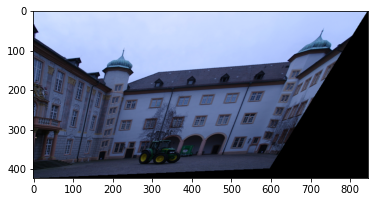

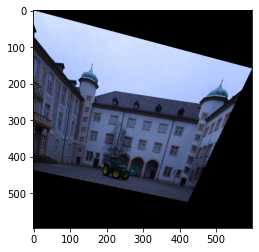

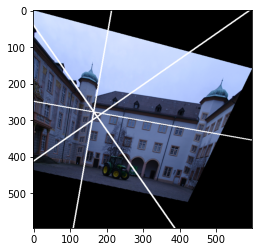

In [10]:
# Get a second orthogonal line pair that is not parallel to the first one
pp1, pp2, pp3, pp4 = (
    get_inters(lr1, lr3),
    get_inters(lr1, lr4),
    get_inters(lr2, lr3),
    get_inters(lr2, lr4),
)
lr5, lr6, = np.cross(pp1, pp4), np.cross(pp2, pp3)



eqs = np.stack([get_equation(lr1, lr3), get_equation(lr5, lr6)])
A = eqs[:, :2]
b = -eqs[:, 2]
sol = np.linalg.solve(A, b)
S = np.array([sol[0], sol[1], sol[1], 1]).reshape((2, 2))
K = np.linalg.cholesky(S)

H_mrec_inv = Hf.id()
H_mrec_inv[0: K.shape[0], 0: K.shape[1]] = K
H_mrec = np.linalg.inv(H_mrec_inv)

img_mrec, shift = apply_H(img_arec_nl, H_mrec)
H_inv_shift = Hf.translate(shift[0], shift[1])
H_mrec_inv = np.linalg.inv(H_mrec) @ H_inv_shift
H_mrec = np.linalg.inv(H_mrec_inv)
plot_img(img_arec_nl)
plot_img(img_mrec)

lmr1, lmr3, lmr5, lmr6 = (
    H_mrec_inv.T @ lr1,
    H_mrec_inv.T @ lr3,
    H_mrec_inv.T @ lr5,
    H_mrec_inv.T @ lr6,
)
# show the transformed lines in the transformed image

size = img_mrec.size
canv = ImageDraw.Draw(img_mrec)
line_draw(lmr1, canv, size)
line_draw(lmr3, canv, size)
line_draw(lmr5, canv, size)
line_draw(lmr6, canv, size)

plot_img(img_mrec)

## **4. Affine and Metric Rectification of the left facade of image 0001**

<span style='color:Green'> - Write the code that rectifies the left facade of image 0001 with
      the stratified method.  </span>
      
Note: For a better visualization of the result crop the initial image so that only the left facade is visible.

<span style='color:Green'> - Show the (properly) transformed lines that are used in every step.  </span>
      

Angles before transform
l1 v l2 = 4.4208049537190846
l1 v l3 = 67.85726110129715
l3 v l4 = 0.12494102020738806
Angles after transform
lr1 v lr2 = 0.0
lr1 v lr3 = 66.17504650222577
lr3 v lr4 = 0.0


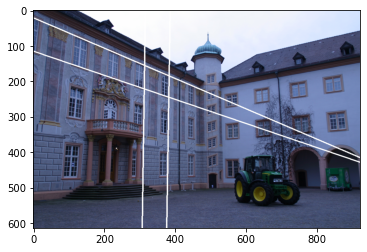

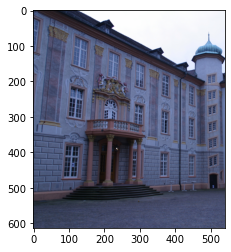

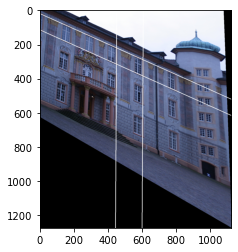

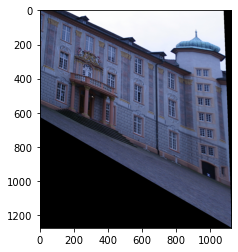

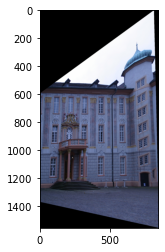

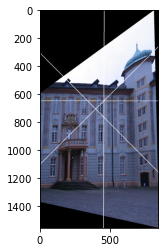

In [11]:
img_path = "./Data/0001_s.png"
lines_path = "./Data/0001_s_info_lines.txt"

img = Image.open(img_path)
A = np.loadtxt(lines_path)

i = 613
p1 = [A[i, 0], A[i, 1], 1]
p2 = [A[i, 2], A[i, 3], 1]
i = 158
p3 = [A[i, 0], A[i, 1], 1]
p4 = [A[i, 2], A[i, 3], 1]
i = 540
p5 = [A[i, 0], A[i, 1], 1]
p6 = [A[i, 2], A[i, 3], 1]
i = 644
p7 = [A[i, 0], A[i, 1], 1]
p8 = [A[i, 2], A[i, 3], 1]

# compute the lines l1, l2, l3, l4, that pass through the different pairs of points
l1, l2, l3, l4 = np.cross(p1, p2), np.cross(p3, p4), np.cross(p5, p6), np.cross(p7, p8)


# show the chosen lines in the image
canv = ImageDraw.Draw(img)
point_color = (0, 0, 255)
line_draw(l1, canv, img.size)
line_draw(l2, canv, img.size)
line_draw(l3, canv, img.size)
line_draw(l4, canv, img.size)


# Draw objects alter img so we have to show it and then reopen the original
plot_img(img)
img = Image.open(img_path)

i = 801
p100 = [A[i,0], A[i,1],1]
p200 = [A[i,2], A[i,3],1]
#print(p100)
#print(p200)

cropped_img = img.crop((0, 0, p200[0], img.size[1]-1)) 
plot_img(cropped_img)

img = cropped_img

# ToDo: compute the homography that affinely rectifies the image
H_arec = rctf.affine_rectification(l1, l2, l3, l4)

img_arec, shift = apply_H(img, H_arec)
H_inv_shift = Hf.translate(shift[0], shift[1])
H_arec_inv = np.linalg.inv(H_arec) @ H_inv_shift
H_arec = np.linalg.inv(H_arec_inv)

lr1, lr2, lr3, lr4 = (
    H_arec_inv.T @ l1,
    H_arec_inv.T @ l2,
    H_arec_inv.T @ l3,
    H_arec_inv.T @ l4,
)
# show the transformed lines in the transformed image

img_arec_nl = img_arec.copy()

size = img_arec.size
canv = ImageDraw.Draw(img_arec)
line_draw(lr1, canv, size)
line_draw(lr2, canv, size)
line_draw(lr3, canv, size)
line_draw(lr4, canv, size)

plot_img(img_arec)

print('Angles before transform')
print(f"l1 v l2 = {angle_diff(compute_angle(l1), compute_angle(l2))}")
print(f"l1 v l3 = {angle_diff(compute_angle(l1), compute_angle(l3))}")
print(f"l3 v l4 = {angle_diff(compute_angle(l3), compute_angle(l4))}")

print('Angles after transform')
print(f"lr1 v lr2 = {angle_diff(compute_angle(lr1), compute_angle(lr2))}")
print(f"lr1 v lr3 = {angle_diff(compute_angle(lr1), compute_angle(lr3))}")
print(f"lr3 v lr4 = {angle_diff(compute_angle(lr3), compute_angle(lr4))}")

# Get a second orthogonal line pair that is not parallel to the first one
pp1, pp2, pp3, pp4 = (
    get_inters(lr1, lr3),
    get_inters(lr1, lr4),
    get_inters(lr2, lr3),
    get_inters(lr2, lr4),
)
lr5, lr6, = np.cross(pp1, pp4), np.cross(pp2, pp3)


eqs = np.stack([get_equation(lr1, lr3), get_equation(lr5, lr6)])
A = eqs[:, :2]
b = -eqs[:, 2]
sol = np.linalg.solve(A, b)
S = np.array([sol[0], sol[1], sol[1], 1]).reshape((2, 2))
K = np.linalg.cholesky(S)

H_mrec_inv = Hf.id()
H_mrec_inv[0: K.shape[0], 0: K.shape[1]] = K
H_mrec = np.linalg.inv(H_mrec_inv)

img_mrec, shift = apply_H(img_arec_nl, H_mrec)

img_mrec = Image.fromarray(crop(np.array(img_mrec)))

H_inv_shift = Hf.translate(shift[0], shift[1])
H_mrec_inv = np.linalg.inv(H_mrec) @ H_inv_shift
H_mrec = np.linalg.inv(H_mrec_inv)
plot_img(img_arec_nl)
plot_img(img_mrec)

lmr1, lmr3, lmr5, lmr6 = (
    H_mrec_inv.T @ lr1,
    H_mrec_inv.T @ lr3,
    H_mrec_inv.T @ lr5,
    H_mrec_inv.T @ lr6,
)
# show the transformed lines in the transformed image

size = img_mrec.size
canv = ImageDraw.Draw(img_mrec)
line_draw(lmr1, canv, size)
line_draw(lmr3, canv, size)
line_draw(lmr5, canv, size)
line_draw(lmr6, canv, size)

plot_img(img_mrec)

## **5. OPTIONAL: Metric Rectification in a single step**

<span style='color:Green'> - Write the code that performs metric rectification in a single step (algorithm pages 55-57, Hartley-Zisserman book). </span>

Note: Use 5 pairs of orthogonal lines. You may consider that windows are square.